In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import bioframe

import cooler
import cooltools 
import cooltools.api.expected

In [2]:
import cooltools.sandbox
import cooltools.sandbox.expected_smoothing

In [3]:
# download test data
# this file is 145 Mb, and may take a few seconds to download
cool_file = cooltools.download_data("HFF_MicroC", cache=True, data_dir='./')    
print(cool_file)

./test.mcool


In [4]:
# Load a Hi-C map at a 1kb resolution from a cooler file.
clr = cooler.Cooler('./test.mcool::/resolutions/1000')

In [5]:
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.core.construction.add_ucsc_name_column(bioframe.make_chromarms(hg38_chromsizes,  hg38_cens))

hg38_arms = hg38_arms[hg38_arms.chrom.isin(clr.chromnames)].reset_index(drop=True)
hg38_arms

,chrom,start,end,name
0,chr2,0,93139351,chr2:0-93139351
1,chr2,93139351,242193529,chr2:93139351-242193529
2,chr17,0,24714921,chr17:0-24714921
3,chr17,24714921,83257441,chr17:24714921-83257441


In [6]:
# cvd == contacts-vs-distance
cvd = cooltools.api.expected.diagsum_symm(
    clr=clr,
    view_df=hg38_arms,
    transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
)

In [ ]:
# import importlib
# importlib.reload(cooltools.sandbox.expected_smoothing)

In [17]:
cvd_smoothed = cooltools.sandbox.expected_smoothing.agg_smooth_cvd(cvd).reset_index()

In [18]:
cvd_smoothed

,region1,region2,level_2,dist,n_valid.smoothed,balanced.sum.smoothed,balanced.avg.smoothed
0,chr17:0-24714921,chr17:0-24714921,0,0,0.000000,0.000000,NaN
1,chr17:0-24714921,chr17:0-24714921,1,1,19748.305903,23.002208,1.164769e-03
2,chr17:0-24714921,chr17:0-24714921,2,2,19672.012304,1914.413783,9.731662e-02
3,chr17:0-24714921,chr17:0-24714921,3,3,19607.556772,945.942439,4.824377e-02
4,chr17:0-24714921,chr17:0-24714921,4,4,19556.911428,536.929382,2.745471e-02
...,...,...,...,...,...,...,...
325449,chr2:93139351-242193529,chr2:93139351-242193529,149050,149050,17234.604470,0.002082,1.207903e-07
325450,chr2:93139351-242193529,chr2:93139351-242193529,149051,149051,17234.382187,0.002082,1.207902e-07
325451,chr2:93139351-242193529,chr2:93139351-242193529,149052,149052,17234.159907,0.002082,1.207902e-07
325452,chr2:93139351-242193529,chr2:93139351-242193529,149053,149053,17233.937632,0.002082,1.207902e-07


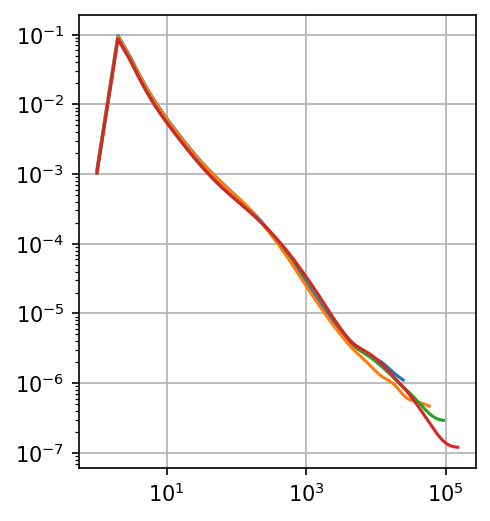

In [26]:
plt.rcParams['figure.dpi'] = 150

# for reg in cvd.region1.unique():
#     cvd_loc = cvd[cvd.region1 == reg]
#     plt.loglog(
#         cvd_loc['diag'],
#         cvd_loc['balanced.sum'] / cvd_loc['n_valid']
#     )

for reg in cvd_smoothed.region1.unique():
    cvd_loc = cvd_smoothed[cvd_smoothed.region1 == reg]

    plt.loglog(
        cvd_loc['dist'],
        cvd_loc['balanced.avg.smoothed']
    )
ax = plt.gca()
ax.set(aspect=1.0);
ax.grid()

In [21]:
# Assign genome-wide P(s) to each region:
cvd_smoothed_gw = cooltools.sandbox.expected_smoothing.agg_smooth_cvd(cvd, groupby=None)

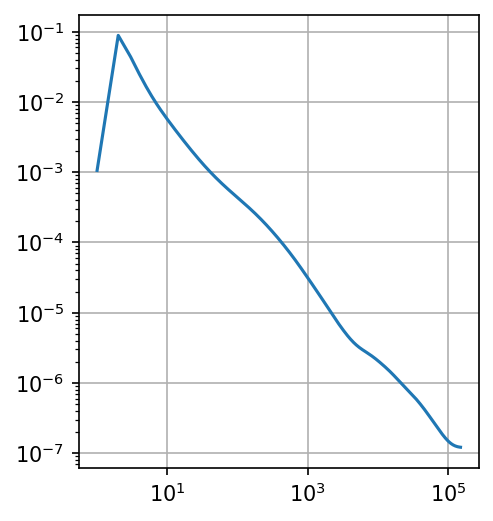

In [27]:
plt.rcParams['figure.dpi'] = 150


plt.loglog(
    cvd_smoothed_gw['dist'],
    cvd_smoothed_gw['balanced.avg.smoothed']
)

ax = plt.gca()
ax.set(aspect=1.0);
ax.grid()